<a href="https://colab.research.google.com/github/sajidcsecu/radioGenomic/blob/main/UnetinGPU_(Fifty_Fifty_Preprocessed_DiceLoss_And_Strong_Augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Code for the Segmentation on Rider Dataset (LUNG1). The Code is worked on the 2D slices over GPU. The balanced sampler, preprocessed the augmentation is used in the code...

# (1) Import Required Libraries

In [1]:
!pip install SimpleITK
!pip install pydicom===2.4.3
!pip install pydicom-seg
!pip install numpy==1.23.5


# (2) Import required Libraries

In [2]:
import os
import random
import time
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    jaccard_score,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
)
from tqdm import tqdm
import shutil
import cv2
from typing import List
import torch.multiprocessing as mp
import h5py
from google.colab import drive
import torch.amp as amp
import pickle
from torch.utils.data import Sampler
import torchvision.transforms.functional as TF

# (3) Mount Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# (4) Data Preperation

In [4]:
class StrongJointTransform:
    def __init__(self, p_flip=0.5, p_rotate=0.5, p_gamma=0.5, p_noise=0.5):
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_gamma = p_gamma
        self.p_noise = p_noise

    def __call__(self, image, mask):
        if random.random() < self.p_flip:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            else:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        if random.random() < self.p_rotate:
            angle = random.choice([90, 180, 270])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        if random.random() < self.p_gamma:
            gamma = random.uniform(0.7, 1.5)
            image = TF.adjust_gamma(image, gamma)

        if random.random() < self.p_noise:
            noise = torch.randn_like(image) * 0.05
            image = torch.clamp(image + noise, 0, 1)

        return image, mask

In [5]:
class BalancedTumorSampler(Sampler):
    def __init__(self, dataset, tumor_ratio=0.5, shuffle=True, index_cache_path=None):
        self.dataset = dataset
        self.tumor_ratio = tumor_ratio
        self.shuffle = shuffle
        self.index_cache_path = index_cache_path

        self.tumor_indices = []
        self.non_tumor_indices = []

        if index_cache_path and os.path.exists(index_cache_path):
            print(f"📂 Loading cached indices from {index_cache_path}")
            with open(index_cache_path, 'rb') as f:
                cached = pickle.load(f)
                self.tumor_indices = cached['tumor']
                self.non_tumor_indices = cached['non_tumor']
            print(f"✅ Loaded: {len(self.tumor_indices)} tumor, {len(self.non_tumor_indices)} non-tumor")
        else:
            print("🛠️ Computing tumor/non-tumor indices...")
            self._prepare_indices()
            if index_cache_path:
                print(f"💾 Saving indices to {index_cache_path}")
                with open(index_cache_path, 'wb') as f:
                    pickle.dump({'tumor': self.tumor_indices, 'non_tumor': self.non_tumor_indices}, f)

    def _prepare_indices(self):
        for idx in range(len(self.dataset)):
            _, mask = self.dataset[idx]
            if mask.sum() > 0:
                self.tumor_indices.append(idx)
            else:
                self.non_tumor_indices.append(idx)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.tumor_indices)
            random.shuffle(self.non_tumor_indices)

        total_samples = min(len(self.tumor_indices), len(self.non_tumor_indices)) * 2
        num_tumor = int(self.tumor_ratio * total_samples)
        num_non_tumor = total_samples - num_tumor

        selected_tumor = self.tumor_indices[:num_tumor]
        selected_non_tumor = self.non_tumor_indices[:num_non_tumor]

        combined = selected_tumor + selected_non_tumor
        if self.shuffle:
            random.shuffle(combined)

        return iter(combined)

    def __len__(self):
        return min(len(self.tumor_indices), len(self.non_tumor_indices)) * 2


In [6]:
class HDF5SegmentationDataset(Dataset):
    def __init__(self, hdf5_path, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.patient_ids = []

        # Read only keys for indexing
        with h5py.File(self.hdf5_path, 'r') as f:
            self.patient_ids = list(f.keys())
            self.slice_indices = [(pid, i) for pid in self.patient_ids for i in range(f[pid]['ct'].shape[0])]

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        pid, slice_idx = self.slice_indices[idx]

        with h5py.File(self.hdf5_path, 'r') as f:
            ct_slice = f[pid]['ct'][slice_idx]
            mask_slice = f[pid]['mask'][slice_idx]

        # Normalize CT to [0, 1]
        ct_slice = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-5)

        # Convert to torch tensors and add channel dim
        ct_tensor = torch.tensor(ct_slice, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.long).unsqueeze(0)

        if self.transform:
            ct_tensor, mask_tensor = self.transform(ct_tensor, mask_tensor)

        return ct_tensor, mask_tensor

# 2. Unet

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, self.dropout(p)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = UpSample(in_channels, out_channels)
        self.conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return self.dropout(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        self.e1 = EncoderBlock(in_channels, 64, dropout=dropout)
        self.e2 = EncoderBlock(64, 128, dropout=dropout)
        self.e3 = EncoderBlock(128, 256, dropout=dropout)
        self.e4 = EncoderBlock(256, 512, dropout=dropout)

        self.b = DoubleConv(512, 1024)
        self.dropout_bottleneck = nn.Dropout(p=dropout)

        self.d1 = DecoderBlock(1024, 512, dropout=dropout)
        self.d2 = DecoderBlock(512, 256, dropout=dropout)
        self.d3 = DecoderBlock(256, 128, dropout=dropout)
        self.d4 = DecoderBlock(128, 64, dropout=dropout)

        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)
        b = self.dropout_bottleneck(b)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        return self.outputs(d4)

# if __name__ == "__main__":
#     # double_conv = DoubleConv(256, 256)
#     # print(double_conv)
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     input_image = torch.randn((1, 1, 512, 512), dtype=torch.float32)
#     model = UNet(1, 1).to(device)
#     input_image = input_image.to(device)
#     out = model(input_image)
#     print(out.shape)
#     print(device)
#     print(torch.cuda.is_available())

## 2. Loss Function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth + self.epsilon)
        return 1 - dice_score

class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (torch.sigmoid(preds) * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (torch.sigmoid(preds).sum() + targets.sum() + self.smooth + self.epsilon)
        bce_loss = self.bce(preds, targets)
        return bce_loss + dice_loss

# 3. Test

In [9]:
class UnetTest:
    def __init__(self, test_result_path: str,metrics_csv, device: torch.device):
        self.test_result_path = test_result_path
        self.device = device
        self.metrics_csv = metrics_csv

        os.makedirs(self.test_result_path, exist_ok=True)

        # Initialize CSV file with headers
        if not os.path.exists(self.metrics_csv):
            with open(self.metrics_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["SampleID", "Jaccard", "F1", "Recall", "Precision", "Accuracy", "Time"])

        print(f"Test results will be saved to: {self.test_result_path}")
        print(f"Using device: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def calculate_metrics(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> List[float]:
        # Apply sigmoid and threshold at 0.5
        y_pred = (y_pred > 0.5).float()

        # Move to CPU and convert to numpy
        y_true_np = y_true.detach().cpu().numpy().astype(bool).reshape(-1)
        y_pred_np = y_pred.detach().cpu().numpy().astype(bool).reshape(-1)

        # If ground truth is completely empty or prediction is empty, set zero_division=0 for clarity
        return [
            jaccard_score(y_true_np, y_pred_np, zero_division=0),
            f1_score(y_true_np, y_pred_np, zero_division=0),
            recall_score(y_true_np, y_pred_np, zero_division=0),
            precision_score(y_true_np, y_pred_np, zero_division=0),
            accuracy_score(y_true_np, y_pred_np)
        ]


    def save_result(self, image: torch.Tensor, org_mask: torch.Tensor, predicted_mask: torch.Tensor, sample_id: int) -> None:
        predicted_mask = (predicted_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        org_mask = (org_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        image = (image.detach().cpu().numpy().squeeze() * 255).astype(np.uint8)

        h, w = image.shape
        line = np.ones((h, 10), dtype=np.uint8) * 128
        cat_images = np.concatenate([image, line, org_mask, line, predicted_mask], axis=1)

        file_name = os.path.join(self.test_result_path, f"sample_{sample_id}.png")
        success = cv2.imwrite(file_name, cat_images)

        if success:
            print(f"✅ Saved: {file_name}")
        else:
            print(f"❌ Failed to save image: {file_name}")

    def append_metrics_to_csv(self, sample_id: int, metrics: List[float], elapsed_time: float) -> None:
        with open(self.metrics_csv, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([sample_id] + [f"{m:.4f}" for m in metrics] + [f"{elapsed_time:.4f}"])

    def test(self, model: torch.nn.Module, test_loader: torch.utils.data.DataLoader) -> None:
        model.eval()
        metrics_score = np.zeros(5)
        time_taken = []

        with torch.no_grad():
            for pid, (x, y) in enumerate(test_loader):
                # if (pid >=2):
                #   break
                x = x.to(self.device, dtype=torch.float32)
                y = y.to(self.device, dtype=torch.float32)

                start_time = time.time()
                y_pred = torch.sigmoid(model(x))
                elapsed_time = time.time() - start_time
                time_taken.append(elapsed_time)

                batch_metrics = self.calculate_metrics(y, y_pred)
                metrics_score += np.array(batch_metrics)

                for idx in range(x.size(0)):
                    sample_id = pid * x.size(0) + idx
                    self.save_result(x[idx], y[idx], y_pred[idx], sample_id)
                    self.append_metrics_to_csv(sample_id, batch_metrics, elapsed_time)

        num_batches = len(test_loader)
        avg_metrics = metrics_score / num_batches

        print(f"\n🧪 Total Batches in Test Set: {num_batches}")
        print(f"📊 Jaccard: {avg_metrics[0]:.4f} | F1: {avg_metrics[1]:.4f} | Recall: {avg_metrics[2]:.4f} | "
              f"Precision: {avg_metrics[3]:.4f} | Accuracy: {avg_metrics[4]:.4f}")
        print(f"⚡ FPS: {1 / np.mean(time_taken):.2f}")


# 4. Training

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=0, path='checkpoint.pt', start_val_loss_min=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path

        self.val_loss_min = start_val_loss_min if start_val_loss_min is not None else np.Inf

    def __call__(self, val_loss, model, epoch=None, optimizer=None):
        if val_loss < self.val_loss_min - self.min_delta:
            self.val_loss_min = val_loss
            self.save_checkpoint(model, epoch, optimizer)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, model, epoch=None, optimizer=None):
        if self.verbose:
            print(f"✅ Validation loss improved. Saving model...")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        }
        torch.save(checkpoint, self.path)


class UnetTrain:
    def __init__(self, model_file, loss_result_path, lr, num_epochs, device):
        self.model_file = model_file
        self.loss_result_path = loss_result_path
        self.lr = lr
        self.num_epochs = num_epochs
        self.device = device

        self.seeding(42)

        print(f"🔧 Training initialized: lr={self.lr}, epochs={self.num_epochs}")
        print(f"📁 Model will be saved to: {self.model_file}")
        print(f"📁 Loss log will be saved to: {self.loss_result_path}")
        print(f"💻 Device in use: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def seeding(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        return int(elapsed_time / 60), int(elapsed_time % 60)

    def train_one_epoch(self, model, loader, optimizer, loss_fn):
        model.train()
        epoch_loss = 0
        scaler = amp.GradScaler()

        for batch_idx, (x, y) in enumerate(loader):
            # if (batch_idx >=10):
            #       break
            x, y = x.to(self.device, dtype=torch.float32), y.to(self.device, dtype=torch.float32)
            optimizer.zero_grad()
            with amp.autocast(device_type=self.device.type):
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def evaluate(self, model, loader, loss_fn):
        model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader):
                # if (batch_idx >=2):
                #     break
                x, y = x.to(self.device, dtype=torch.float32), y.to(self.device, dtype=torch.float32)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def execute(self, train_loader, valid_loader):
        model = UNet(in_channels=1, out_channels=1, dropout=0.3).to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        loss_fn = DiceBCELoss()

        start_epoch = 1
        history = {"train_loss": [], "valid_loss": []}
        start_val_loss_min = None

        # Resume from checkpoint if exists
        if os.path.exists(self.model_file):
            checkpoint = torch.load(self.model_file, map_location=self.device)
            model.load_state_dict(checkpoint['model_state_dict'])
            if checkpoint['optimizer_state_dict']:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Resume from CSV if exists
        if os.path.exists(self.loss_result_path):
            with open(self.loss_result_path, 'r') as file:
                reader = csv.reader(file)
                header = next(reader)
                rows = list(reader)
                if rows:
                    last_row = rows[-1]
                    last_epoch = int(last_row[0])
                    start_epoch = last_epoch + 1
                    history['train_loss'] = [float(r[1]) for r in rows]
                    history['valid_loss'] = [float(r[2]) for r in rows]
                    start_val_loss_min = min(history['valid_loss'])
                    print(f"🔁 Resuming from epoch {start_epoch}...")
                    # Backup CSV
                    shutil.copy(self.loss_result_path, self.loss_result_path.replace(".csv", "_backup.csv"))

        # Setup EarlyStopping
        early_stopping = EarlyStopping(patience=10, min_delta=0.0005, path=self.model_file, start_val_loss_min=start_val_loss_min)

        # If new file, write header
        if not os.path.exists(self.loss_result_path):
            with open(self.loss_result_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["Epoch", "Train Loss", "Valid Loss"])

        # Training Loop
        for epoch in tqdm(range(start_epoch, self.num_epochs + 1), desc="🏋️ Training"):
            start_time = time.time()

            train_loss = self.train_one_epoch(model, train_loader, optimizer, loss_fn)
            valid_loss = self.evaluate(model, valid_loader, loss_fn)
            scheduler.step()

            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time=time.time())

            print(f"📅 Epoch {epoch:03d} | ⏱️ {epoch_mins}m {epoch_secs}s | 🔥 Train: {train_loss:.8f} | 🎯 Val: {valid_loss:.8f}")

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)

            # Write new entry to CSV
            with open(self.loss_result_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([epoch, train_loss, valid_loss])

            # Early stopping check
            if early_stopping(valid_loss, model, epoch, optimizer):
                print("🛑 Early stopping triggered.")
                break

In [11]:
class UnetPipeline:
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Setup paths
        self.setup_paths()

        # Prepare datasets
        print("📦 Loading datasets...")
        self.train_loader, self.valid_loader, self.test_loader = self.prepare_loaders()

    def setup_paths(self):
        os.chdir(self.config['target_dir'])
        print(f"📁 Current Directory: {os.getcwd()}")

        self.output_dir = os.path.join(".", "results", self.config['output_folder_name'])
        os.makedirs(self.output_dir, exist_ok=True)

        self.loss_result_file = os.path.join(self.output_dir, "train_and_valid_loss_results.csv")
        self.model_file = os.path.join(self.output_dir, "model.pth")
        self.test_metrics_file = os.path.join(self.output_dir, "test_metrics.csv")
        self.test_result_path = os.path.join(self.output_dir, "test_outputs")
        os.makedirs(self.test_result_path, exist_ok=True)

        self.dataset_dir = os.path.join("./datasets", f"Datasets_{self.config['transformation']}")

    def prepare_loaders(self):
        train_path = os.path.join(self.dataset_dir, "train_dataset.hdf5")
        valid_path = os.path.join(self.dataset_dir, "valid_dataset.hdf5")
        test_path = os.path.join(self.dataset_dir, "test_dataset.hdf5")

        train_transform = StrongJointTransform()

        train_dataset = HDF5SegmentationDataset(train_path, transform=train_transform)
        valid_dataset = HDF5SegmentationDataset(valid_path, transform=None)
        test_dataset  = HDF5SegmentationDataset(test_path, transform=None)

        sampler = BalancedTumorSampler(
            train_dataset,
            tumor_ratio=0.5,
            shuffle=True,
            index_cache_path=os.path.join(self.dataset_dir, 'tumor_indices.pkl')
        )

        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], sampler=sampler, num_workers=0, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
        test_loader  = DataLoader(test_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

        print(f"✅ Dataset sizes — Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

        return train_loader, valid_loader, test_loader

    def train(self):
        trainer = UnetTrain(
            model_file=self.model_file,
            loss_result_path=self.loss_result_file,
            lr=self.config['learning_rate'],
            num_epochs=self.config['num_epochs'],
            device=self.device
        )
        trainer.execute(self.train_loader, self.valid_loader)

    def test(self):
        model = UNet(in_channels=1, out_channels=1).to(self.device)
        checkpoint = torch.load(self.model_file, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])

        tester = UnetTest(self.test_result_path, self.test_metrics_file, self.device)
        tester.test(model, self.test_loader)

    def run(self):
        self.train()
        self.test()


def main():
    config = {
        'target_dir': "/content/drive/MyDrive/PhDwork/Segmentation",
        'output_folder_name': "Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation",
        'transformation': "PreprocessedCT_With_Empty_NonEmpty_slices_In_Train",
        'batch_size': 16,
        'num_epochs': 150,
        'learning_rate': 1e-5,
    }

    pipeline = UnetPipeline(config)
    pipeline.run()


if __name__ == "__main__":
    mp.set_start_method('spawn')
    main()


📁 Current Directory: /content/drive/MyDrive/PhDwork/Segmentation
📦 Loading datasets...
📂 Loading cached indices from ./datasets/Datasets_PreprocessedCT_With_Empty_NonEmpty_slices_In_Train/tumor_indices.pkl
✅ Loaded: 5858 tumor, 35476 non-tumor
✅ Dataset sizes — Train: 41334, Valid: 5141, Test: 4653
🔧 Training initialized: lr=1e-05, epochs=150
📁 Model will be saved to: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/model.pth
📁 Loss log will be saved to: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/train_and_valid_loss_results.csv
💻 Device in use: cuda (CUDA available: True)
🔁 Resuming from epoch 47...


🏋️ Training:   1%|          | 1/104 [36:31<62:42:03, 2191.49s/it]

📅 Epoch 047 | ⏱️ 36m 31s | 🔥 Train: 0.59614749 | 🎯 Val: 0.92160783
⏳ EarlyStopping counter: 1 out of 10
📅 Epoch 048 | ⏱️ 30m 39s | 🔥 Train: 0.58014033 | 🎯 Val: 0.91969105
✅ Validation loss improved. Saving model...


🏋️ Training:   2%|▏         | 2/104 [1:07:11<56:14:06, 1984.77s/it]

📅 Epoch 049 | ⏱️ 30m 43s | 🔥 Train: 0.55623840 | 🎯 Val: 0.91214989
✅ Validation loss improved. Saving model...


🏋️ Training:   3%|▎         | 3/104 [1:37:55<53:52:47, 1920.47s/it]

📅 Epoch 050 | ⏱️ 30m 47s | 🔥 Train: 0.52657438 | 🎯 Val: 0.91117610
✅ Validation loss improved. Saving model...


🏋️ Training:   4%|▍         | 4/104 [2:08:44<52:33:29, 1892.10s/it]

📅 Epoch 051 | ⏱️ 30m 42s | 🔥 Train: 0.50131113 | 🎯 Val: 0.90783355
✅ Validation loss improved. Saving model...


🏋️ Training:   5%|▍         | 5/104 [2:39:27<51:33:04, 1874.59s/it]

📅 Epoch 052 | ⏱️ 30m 46s | 🔥 Train: 0.48289301 | 🎯 Val: 0.90321806
✅ Validation loss improved. Saving model...


🏋️ Training:   6%|▌         | 6/104 [3:10:15<50:46:48, 1865.39s/it]

📅 Epoch 053 | ⏱️ 30m 47s | 🔥 Train: 0.47252841 | 🎯 Val: 0.89831745
✅ Validation loss improved. Saving model...


🏋️ Training:   8%|▊         | 8/104 [4:11:50<49:28:59, 1855.62s/it]

📅 Epoch 054 | ⏱️ 30m 46s | 🔥 Train: 0.45456092 | 🎯 Val: 0.89810328
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:   9%|▊         | 9/104 [4:42:26<48:48:35, 1849.63s/it]

📅 Epoch 055 | ⏱️ 30m 36s | 🔥 Train: 0.45002705 | 🎯 Val: 0.89835552
⏳ EarlyStopping counter: 2 out of 10
📅 Epoch 056 | ⏱️ 30m 39s | 🔥 Train: 0.44620232 | 🎯 Val: 0.89745615
✅ Validation loss improved. Saving model...


🏋️ Training:  11%|█         | 11/104 [5:43:52<47:42:08, 1846.55s/it]

📅 Epoch 057 | ⏱️ 30m 46s | 🔥 Train: 0.46412914 | 🎯 Val: 0.89908227
⏳ EarlyStopping counter: 1 out of 10
📅 Epoch 058 | ⏱️ 30m 42s | 🔥 Train: 0.44994352 | 🎯 Val: 0.89403810
✅ Validation loss improved. Saving model...


🏋️ Training:  12%|█▏        | 12/104 [6:14:35<47:09:46, 1845.51s/it]

📅 Epoch 059 | ⏱️ 30m 43s | 🔥 Train: 0.42654803 | 🎯 Val: 0.89172010
✅ Validation loss improved. Saving model...


🏋️ Training:  13%|█▎        | 14/104 [7:16:10<46:09:55, 1846.62s/it]

📅 Epoch 060 | ⏱️ 30m 49s | 🔥 Train: 0.40945416 | 🎯 Val: 0.89171318
⏳ EarlyStopping counter: 1 out of 10
📅 Epoch 061 | ⏱️ 30m 37s | 🔥 Train: 0.39562147 | 🎯 Val: 0.88410748
✅ Validation loss improved. Saving model...


🏋️ Training:  14%|█▍        | 15/104 [7:46:48<45:35:33, 1844.19s/it]

📅 Epoch 062 | ⏱️ 30m 49s | 🔥 Train: 0.38053012 | 🎯 Val: 0.88183371
✅ Validation loss improved. Saving model...


🏋️ Training:  15%|█▌        | 16/104 [8:17:39<45:07:43, 1846.18s/it]

📅 Epoch 063 | ⏱️ 30m 46s | 🔥 Train: 0.37267342 | 🎯 Val: 0.87927645
✅ Validation loss improved. Saving model...


🏋️ Training:  17%|█▋        | 18/104 [9:19:14<44:07:05, 1846.80s/it]

📅 Epoch 064 | ⏱️ 30m 47s | 🔥 Train: 0.35511487 | 🎯 Val: 0.88134511
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:  18%|█▊        | 19/104 [9:49:54<43:33:26, 1844.78s/it]

📅 Epoch 065 | ⏱️ 30m 40s | 🔥 Train: 0.34782605 | 🎯 Val: 0.88008072
⏳ EarlyStopping counter: 2 out of 10
📅 Epoch 066 | ⏱️ 30m 41s | 🔥 Train: 0.34038730 | 🎯 Val: 0.87512582
✅ Validation loss improved. Saving model...


🏋️ Training:  20%|██        | 21/104 [10:51:23<42:31:55, 1844.76s/it]

📅 Epoch 067 | ⏱️ 30m 46s | 🔥 Train: 0.33644431 | 🎯 Val: 0.87748005
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:  21%|██        | 22/104 [11:21:59<41:57:29, 1842.06s/it]

📅 Epoch 068 | ⏱️ 30m 35s | 🔥 Train: 0.32402669 | 🎯 Val: 0.87949727
⏳ EarlyStopping counter: 2 out of 10


🏋️ Training:  22%|██▏       | 23/104 [11:52:41<41:27:07, 1842.31s/it]

📅 Epoch 069 | ⏱️ 30m 42s | 🔥 Train: 0.32021854 | 🎯 Val: 0.88137093
⏳ EarlyStopping counter: 3 out of 10
📅 Epoch 070 | ⏱️ 30m 36s | 🔥 Train: 0.31339839 | 🎯 Val: 0.87424997
✅ Validation loss improved. Saving model...


🏋️ Training:  24%|██▍       | 25/104 [12:54:08<40:27:11, 1843.43s/it]

📅 Epoch 071 | ⏱️ 30m 49s | 🔥 Train: 0.30584491 | 🎯 Val: 0.87532218
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:  25%|██▌       | 26/104 [13:24:46<39:54:09, 1841.66s/it]

📅 Epoch 072 | ⏱️ 30m 37s | 🔥 Train: 0.30192289 | 🎯 Val: 0.87623871
⏳ EarlyStopping counter: 2 out of 10


🏋️ Training:  26%|██▌       | 27/104 [13:55:21<39:20:52, 1839.64s/it]

📅 Epoch 073 | ⏱️ 30m 34s | 🔥 Train: 0.29719583 | 🎯 Val: 0.87550662
⏳ EarlyStopping counter: 3 out of 10
📅 Epoch 074 | ⏱️ 30m 39s | 🔥 Train: 0.29718070 | 🎯 Val: 0.87368911
✅ Validation loss improved. Saving model...


🏋️ Training:  28%|██▊       | 29/104 [14:56:46<38:21:33, 1841.24s/it]

📅 Epoch 075 | ⏱️ 30m 44s | 🔥 Train: 0.29279272 | 🎯 Val: 0.87378203
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:  29%|██▉       | 30/104 [15:27:23<37:49:17, 1839.97s/it]

📅 Epoch 076 | ⏱️ 30m 36s | 🔥 Train: 0.29544561 | 🎯 Val: 0.87448537
⏳ EarlyStopping counter: 2 out of 10


🏋️ Training:  30%|██▉       | 31/104 [15:58:01<37:18:04, 1839.51s/it]

📅 Epoch 077 | ⏱️ 30m 38s | 🔥 Train: 0.31723292 | 🎯 Val: 0.88182959
⏳ EarlyStopping counter: 3 out of 10


🏋️ Training:  31%|███       | 32/104 [16:28:39<36:46:41, 1838.91s/it]

📅 Epoch 078 | ⏱️ 30m 37s | 🔥 Train: 0.32334837 | 🎯 Val: 0.87651702
⏳ EarlyStopping counter: 4 out of 10


🏋️ Training:  32%|███▏      | 33/104 [16:59:16<36:15:19, 1838.30s/it]

📅 Epoch 079 | ⏱️ 30m 36s | 🔥 Train: 0.31039840 | 🎯 Val: 0.87855318
⏳ EarlyStopping counter: 5 out of 10


🏋️ Training:  33%|███▎      | 34/104 [17:29:51<35:43:37, 1837.39s/it]

📅 Epoch 080 | ⏱️ 30m 35s | 🔥 Train: 0.30521908 | 🎯 Val: 0.87386165
⏳ EarlyStopping counter: 6 out of 10


🏋️ Training:  34%|███▎      | 35/104 [18:00:31<35:14:05, 1838.34s/it]

📅 Epoch 081 | ⏱️ 30m 40s | 🔥 Train: 0.29989929 | 🎯 Val: 0.87734829
⏳ EarlyStopping counter: 7 out of 10


🏋️ Training:  35%|███▍      | 36/104 [18:31:14<34:44:54, 1839.63s/it]

📅 Epoch 082 | ⏱️ 30m 42s | 🔥 Train: 0.29798781 | 🎯 Val: 0.87816257
⏳ EarlyStopping counter: 8 out of 10


🏋️ Training:  36%|███▌      | 37/104 [19:01:58<34:15:35, 1840.83s/it]

📅 Epoch 083 | ⏱️ 30m 43s | 🔥 Train: 0.29764994 | 🎯 Val: 0.87758327
⏳ EarlyStopping counter: 9 out of 10


🏋️ Training:  36%|███▌      | 37/104 [19:32:41<35:23:31, 1901.66s/it]

📅 Epoch 084 | ⏱️ 30m 43s | 🔥 Train: 0.28252017 | 🎯 Val: 0.87666239
⏳ EarlyStopping counter: 10 out of 10
🛑 Early stopping triggered.


Test results will be saved to: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs
Using device: cuda (CUDA available: True)
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_0.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_1.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_2.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_3.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_4.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_5.png
✅ Saved: ./results/Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_6.png
✅ Saved: ./results/Results_PreProcessedCT_Fif

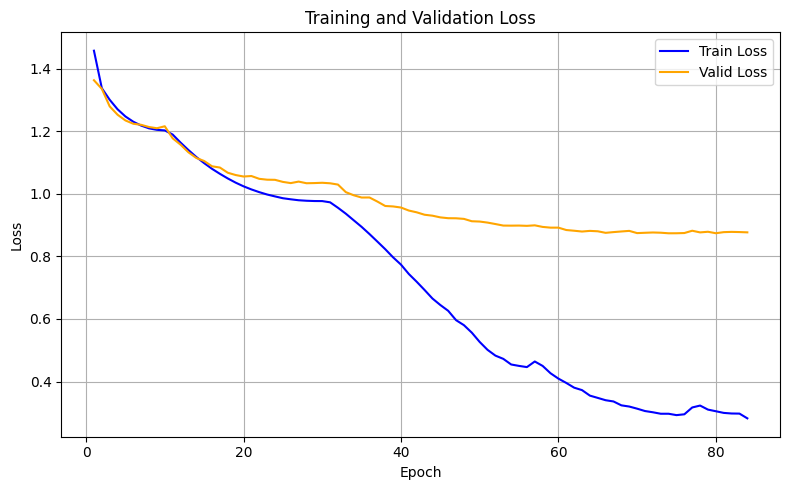

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List
import os
import csv


class LossPlotter:
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        self.data = self._load_data()

    def _load_data(self):
        if not self.csv_path.exists():
            raise FileNotFoundError(f"CSV file not found: {self.csv_path}")
        df = pd.read_csv(self.csv_path, index_col=0)  # Read row labels as index
        return df  # Make rows into columns

    def plot(self, title: str = "Training and Validation Loss", save_path= None):
        plt.figure(figsize=(8, 5))
        plt.plot(self.data.index, self.data['Train Loss'], label='Train Loss', color='blue')
        plt.plot(self.data.index, self.data['Valid Loss'], label='Valid Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_path:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, format='pdf')
            print(f"[INFO] Loss plot saved to {save_path}")
        else:
            plt.show()

        plt.close()

if __name__ == "__main__":
    target_dir = "/content/drive/MyDrive/PhDwork/Segmentation"
    os.chdir(target_dir)
    loss_result_file = os.path.join(".","results",f"Results_PreProcessedCT_Fifty_Fifty_DiceLoss_And_Strong_Augmentation","train_and_valid_loss_results.csv")
    plotter = LossPlotter(loss_result_file)
    plotter.plot()
